In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import pathlib
import os
import matplotlib.pyplot as plt
import seaborn as sns 

In [13]:
def get_model(optimizer, loss, metrics):
    input_ = tf.keras.layers.Input(shape=(224, 224, 1), name="INPUT")
    normalization = tf.keras.layers.Rescaling(1./255)(input_) # Standardize the data
    conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(7, 7), strides=1, activation="relu", padding="same", name="CONV1")(normalization) 
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="POOL1")(conv1) 
    conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(7, 7), strides=1, activation="relu", padding="same", name="CONV2")(pool1)
    concat1 = tf.keras.layers.Concatenate()([pool1, conv2])
    
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="POOL2")(concat1)
    conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=1, activation="relu", padding="same", name="CONV3")(pool2)
    concat2 = tf.keras.layers.Concatenate()([pool2, conv3])
    
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="POOL3")(concat2)
    conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=1, activation="relu", padding="same", name="CONV4")(pool3)
    concat3 = tf.keras.layers.Concatenate()([pool3, conv4])
    
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="POOL4")(concat3)
    flatten = tf.keras.layers.Flatten()(pool4)
    fc1 = tf.keras.layers.Dense(4096, activation='relu')(flatten)
    dropout1 = tf.keras.layers.Dropout(0.5)(fc1)
    fc2 = tf.keras.layers.Dense(2048, activation='relu')(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.5)(fc2)
    
    output = tf.keras.layers.Dense(7, activation='softmax')(dropout2)
    
    model = tf.keras.Model(
        inputs=[input_],
        outputs=[output]
    )

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

Load in / prep the data

In [34]:
train_dir = pathlib.Path("Train v3").with_suffix('')
test_dir = pathlib.Path("Test").with_suffix('')

In [ ]:
print(f"Number of images for training/val: {len(list(train_dir.glob('*/*.jpg')))}")
print(f"NUmber of images for testing: {len(list(test_dir.glob('*/*.jpg')))}") 

In [ ]:
# Display an image
i = list(train_dir.glob('Surprise/*'))
Image.open(str(i[0]))

In [36]:
# Check how many samples fall into each emotion category
print("Number of samples in each emotion category in the Train/Val set")
for e in ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]:
    print(f"Emotion:{e}, # Samples:{len(list(train_dir.glob(f'{e}/*')))}")

Number of samples in each emotion category in the Train/Val set
Emotion:Angry, # Samples:2040
Emotion:Disgust, # Samples:461
Emotion:Fear, # Samples:2096
Emotion:Happy, # Samples:3720
Emotion:Neutral, # Samples:2168
Emotion:Sad, # Samples:2304
Emotion:Surprise, # Samples:1880


In [ ]:
# Find duplicate files between train/val and test sets

emotion = "Happy"

d1 = pathlib.Path(f"Train v2/{emotion}").with_suffix('')
d2 = pathlib.Path(f"Test v2/{emotion}").with_suffix('')

l1 = list(d1.glob('*.jpg'))
for i in range(len(l1)):
    l1[i] = str(l1[i]).split('\\')[2]

l2 = list(d2.glob('*.jpg'))

for i in range(len(l2)):
    l2[i] = str(l2[i]).split('\\')[2]

l1 = set(l1)
l2 = set(l2)

duplicates = l1.intersection(l2)
duplicates

In [58]:
# Drop the duplicate files from the training set
for file in duplicates:
    os.remove(f'Train v2/{emotion}/{file}')

In [37]:
# Convert image folders to TF dataset

im_size = (224, 224)
val_split = 0.1
batch_size = 32
seed = 13
mode = "grayscale"

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=val_split,
    subset="training",
    seed=seed,
    image_size=(im_size),
    batch_size=batch_size,
    color_mode=mode
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=val_split,
    subset="validation",
    seed=seed,
    image_size=(im_size),
    batch_size=batch_size,
    color_mode=mode
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=im_size,
    batch_size=batch_size,
    color_mode=mode
)

Found 14669 files belonging to 7 classes.
Using 13203 files for training.
Found 14669 files belonging to 7 classes.
Using 1466 files for validation.
Found 210 files belonging to 7 classes.


Train Model

In [38]:
model = get_model(optimizer=tf.keras.optimizers.Adam(), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                  metrics=['accuracy']);

In [39]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=(val_ds)
)

Epoch 1/10


413/413 [==============================] - 1493s 4s/step - loss: 1.9023 - accuracy: 0.2876 - val_loss: 1.6983 - val_accuracy: 0.3431
Epoch 2/10
413/413 [==============================] - 1488s 4s/step - loss: 1.6299 - accuracy: 0.3613 - val_loss: 1.5770 - val_accuracy: 0.3909
Epoch 3/10
413/413 [==============================] - 1467s 4s/step - loss: 1.4952 - accuracy: 0.4265 - val_loss: 1.5213 - val_accuracy: 0.4100
Epoch 4/10
413/413 [==============================] - 1494s 4s/step - loss: 1.3795 - accuracy: 0.4766 - val_loss: 1.4943 - val_accuracy: 0.4154
Epoch 5/10
413/413 [==============================] - 1484s 4s/step - loss: 1.2335 - accuracy: 0.5334 - val_loss: 1.4668 - val_accuracy: 0.4584
Epoch 6/10
413/413 [==============================] - 1521s 4s/step - loss: 1.0580 - accuracy: 0.6038 - val_loss: 1.4506 - val_accuracy: 0.4768
Epoch 7/10
413/413 [==============================] - 1506s 4s/step - loss: 0.8601 - accuracy: 0.6839 - val_loss: 1.5946 - val_accuracy: 0.4523
Epo

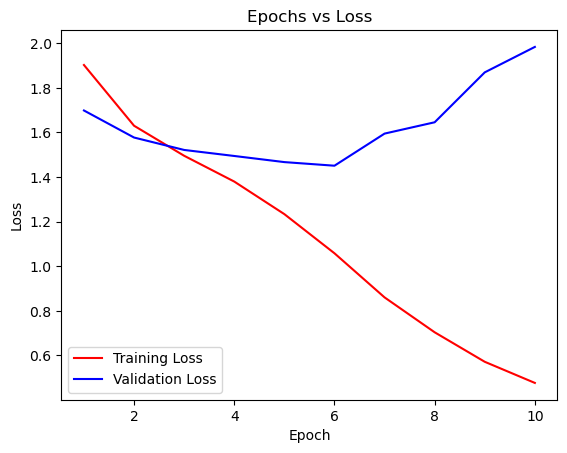

In [40]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'r-')
plt.plot(epochs, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.show()

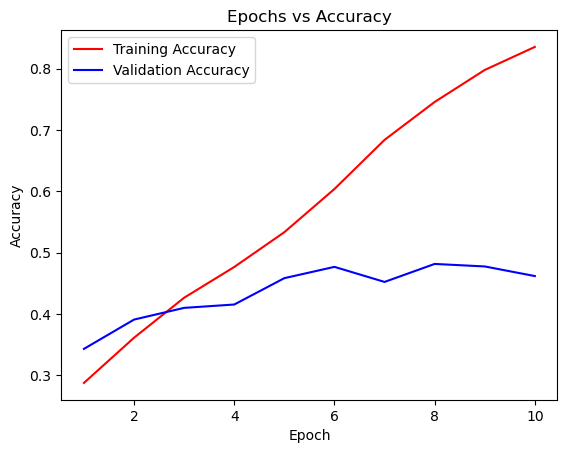

In [41]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.plot(epochs, training_accuracy, 'r-')
plt.plot(epochs, validation_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy')
plt.show()

Make Predictions

In [ ]:
predicted = []
actual = []

for images, labels in test_ds:
    probabilities = model.predict(images)

    for pred in probabilities:
        predicted.append(np.argmax(pred))
    
    for l in labels:
        actual.append(l)

In [ ]:
expressions = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

for i in range(len(actual)):
    print(f"Actual={expressions[actual[i].numpy()]}, Predicted={expressions[predicted[i]]}")

Confusion Matrix

In [43]:
array = tf.math.confusion_matrix(labels=actual, predictions=predicted)

In [ ]:
plt.figure(figsize=(10,7))
l = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
sns.heatmap(array, annot=True, cmap=sns.color_palette("Greens"), xticklabels=l, yticklabels=l).set(xlabel="Predicted", ylabel="Actual")

Model Metrics

In [25]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [ ]:
print(f"F1-Score:   {dict( zip( l, f1_score(actual, predicted, average=None) ) )}")
print(f"Accuracy:   {accuracy_score(actual, predicted)}")
print(f"Precision:  {dict( zip( l, precision_score(actual, predicted, average=None) ) )}")
print(f"Recall:     {dict( zip( l, recall_score(actual, predicted, average=None) ) )}")

Save a model

In [47]:
model.save('Models/v4.keras')

Load a model

In [31]:
m = tf.keras.models.load_model('v2.keras')